In [114]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, cross_validate, StratifiedKFold

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier # instalado a parte - conda install -c conda-forge py-xgboost
from lightgbm import LGBMClassifier # instalado a parte - conda install -c conda-forge lightgbm


from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn import preprocessing

import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.efficientnet import EfficientNetB0, EfficientNetB1, EfficientNetB2, EfficientNetB3, EfficientNetB4, EfficientNetB5, EfficientNetB6, EfficientNetB7
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.applications.densenet import DenseNet201

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import tensorflow.keras as keras

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

import math

import os
from PIL import Image

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


## Parâmetros

In [3]:
percentege_test_size = 0.2
undersampling_size = -1 # -1 para não fazer undersampling

BATCH_SIZE = 16

# fig preprocessing
# largura = 150
# altura = 150
modo_de_cor = 'rgb' # rgb, grayscale, rgba
# fig preprocessing

diretorio = './PokemonData/'
# diretorio = '../dados classificacao imagens/dataset-documentos-full/'
# diretorio = '../dados classificacao imagens/pneumonia/'
# diretorio = '../dados classificacao imagens/star-wars/'
# diretorio = '/home/carlos/Downloads/dados-docs/'
# diretorio = '../dados classificacao imagens/gatos-patos-caes-rapozas-coelhos/treino/'

## Carregando Dataset

In [4]:
targets = [x[0].replace(diretorio,'') for x in os.walk(diretorio)]

targets = targets[1:len(targets)] # exclui o primeiro da lista pq é o próprio diretório

dados = []

for classe in targets:
    imagens = os.listdir(diretorio+classe)
    i = 0
    for img in imagens:
        i+=1
        
        if (not '.txt' in img) and (not 'segmentation' in img) and (not 'desktop.ini' in img) and (not '.svg' in img):
            dados.append([diretorio+classe+'/'+img,classe])
        
        if(i == undersampling_size and undersampling_size != -1):
            break

dados = np.array(dados)

np.random.shuffle(dados)
            
df_dados = pd.DataFrame(dados,columns=['image','target'])

df_dados

image      target
0     ./PokemonData/Diglett/03af4fdc12d84ac78b047dca...     Diglett
1     ./PokemonData/Articuno/d383a647428b4acca6618bf...    Articuno
2     ./PokemonData/Exeggutor/6df4b0c0885d47149e015a...   Exeggutor
3     ./PokemonData/Kabutops/787577b4f8854d298bb0a47...    Kabutops
4     ./PokemonData/Abra/34532bb006714727ade4075f0a7...        Abra
...                                                 ...         ...
6820  ./PokemonData/Wigglytuff/d38b59e1014d4838bea6f...  Wigglytuff
6821  ./PokemonData/Rapidash/94380d6583d74c5dae4c5fc...    Rapidash
6822  ./PokemonData/Exeggcute/76b20bb1256a4f32bbbd38...   Exeggcute
6823  ./PokemonData/Vaporeon/bbbd0675cfb44c4e8c1af1c...    Vaporeon
6824  ./PokemonData/Venusaur/f7d8e44a9bda4373bc9366a...    Venusaur

[6825 rows x 2 columns]

## Analisando Dados

In [5]:
print(f'Quantidade de classes totais: {df_dados["target"].nunique()}')
print(f'Quantidade de imagens totais: {df_dados["target"].count()}')
print(f'Média de imagens por classe: {df_dados["target"].value_counts().mean()}')
print(f'Menor quantidade de imagens em uma classe: {df_dados["target"].value_counts().min()}')
print(f'Maior quantidade de imagens em uma classe: {df_dados["target"].value_counts().max()}')

Quantidade de classes totais: 150
Quantidade de imagens totais: 6825
Média de imagens por classe: 45.5
Menor quantidade de imagens em uma classe: 26
Maior quantidade de imagens em uma classe: 66


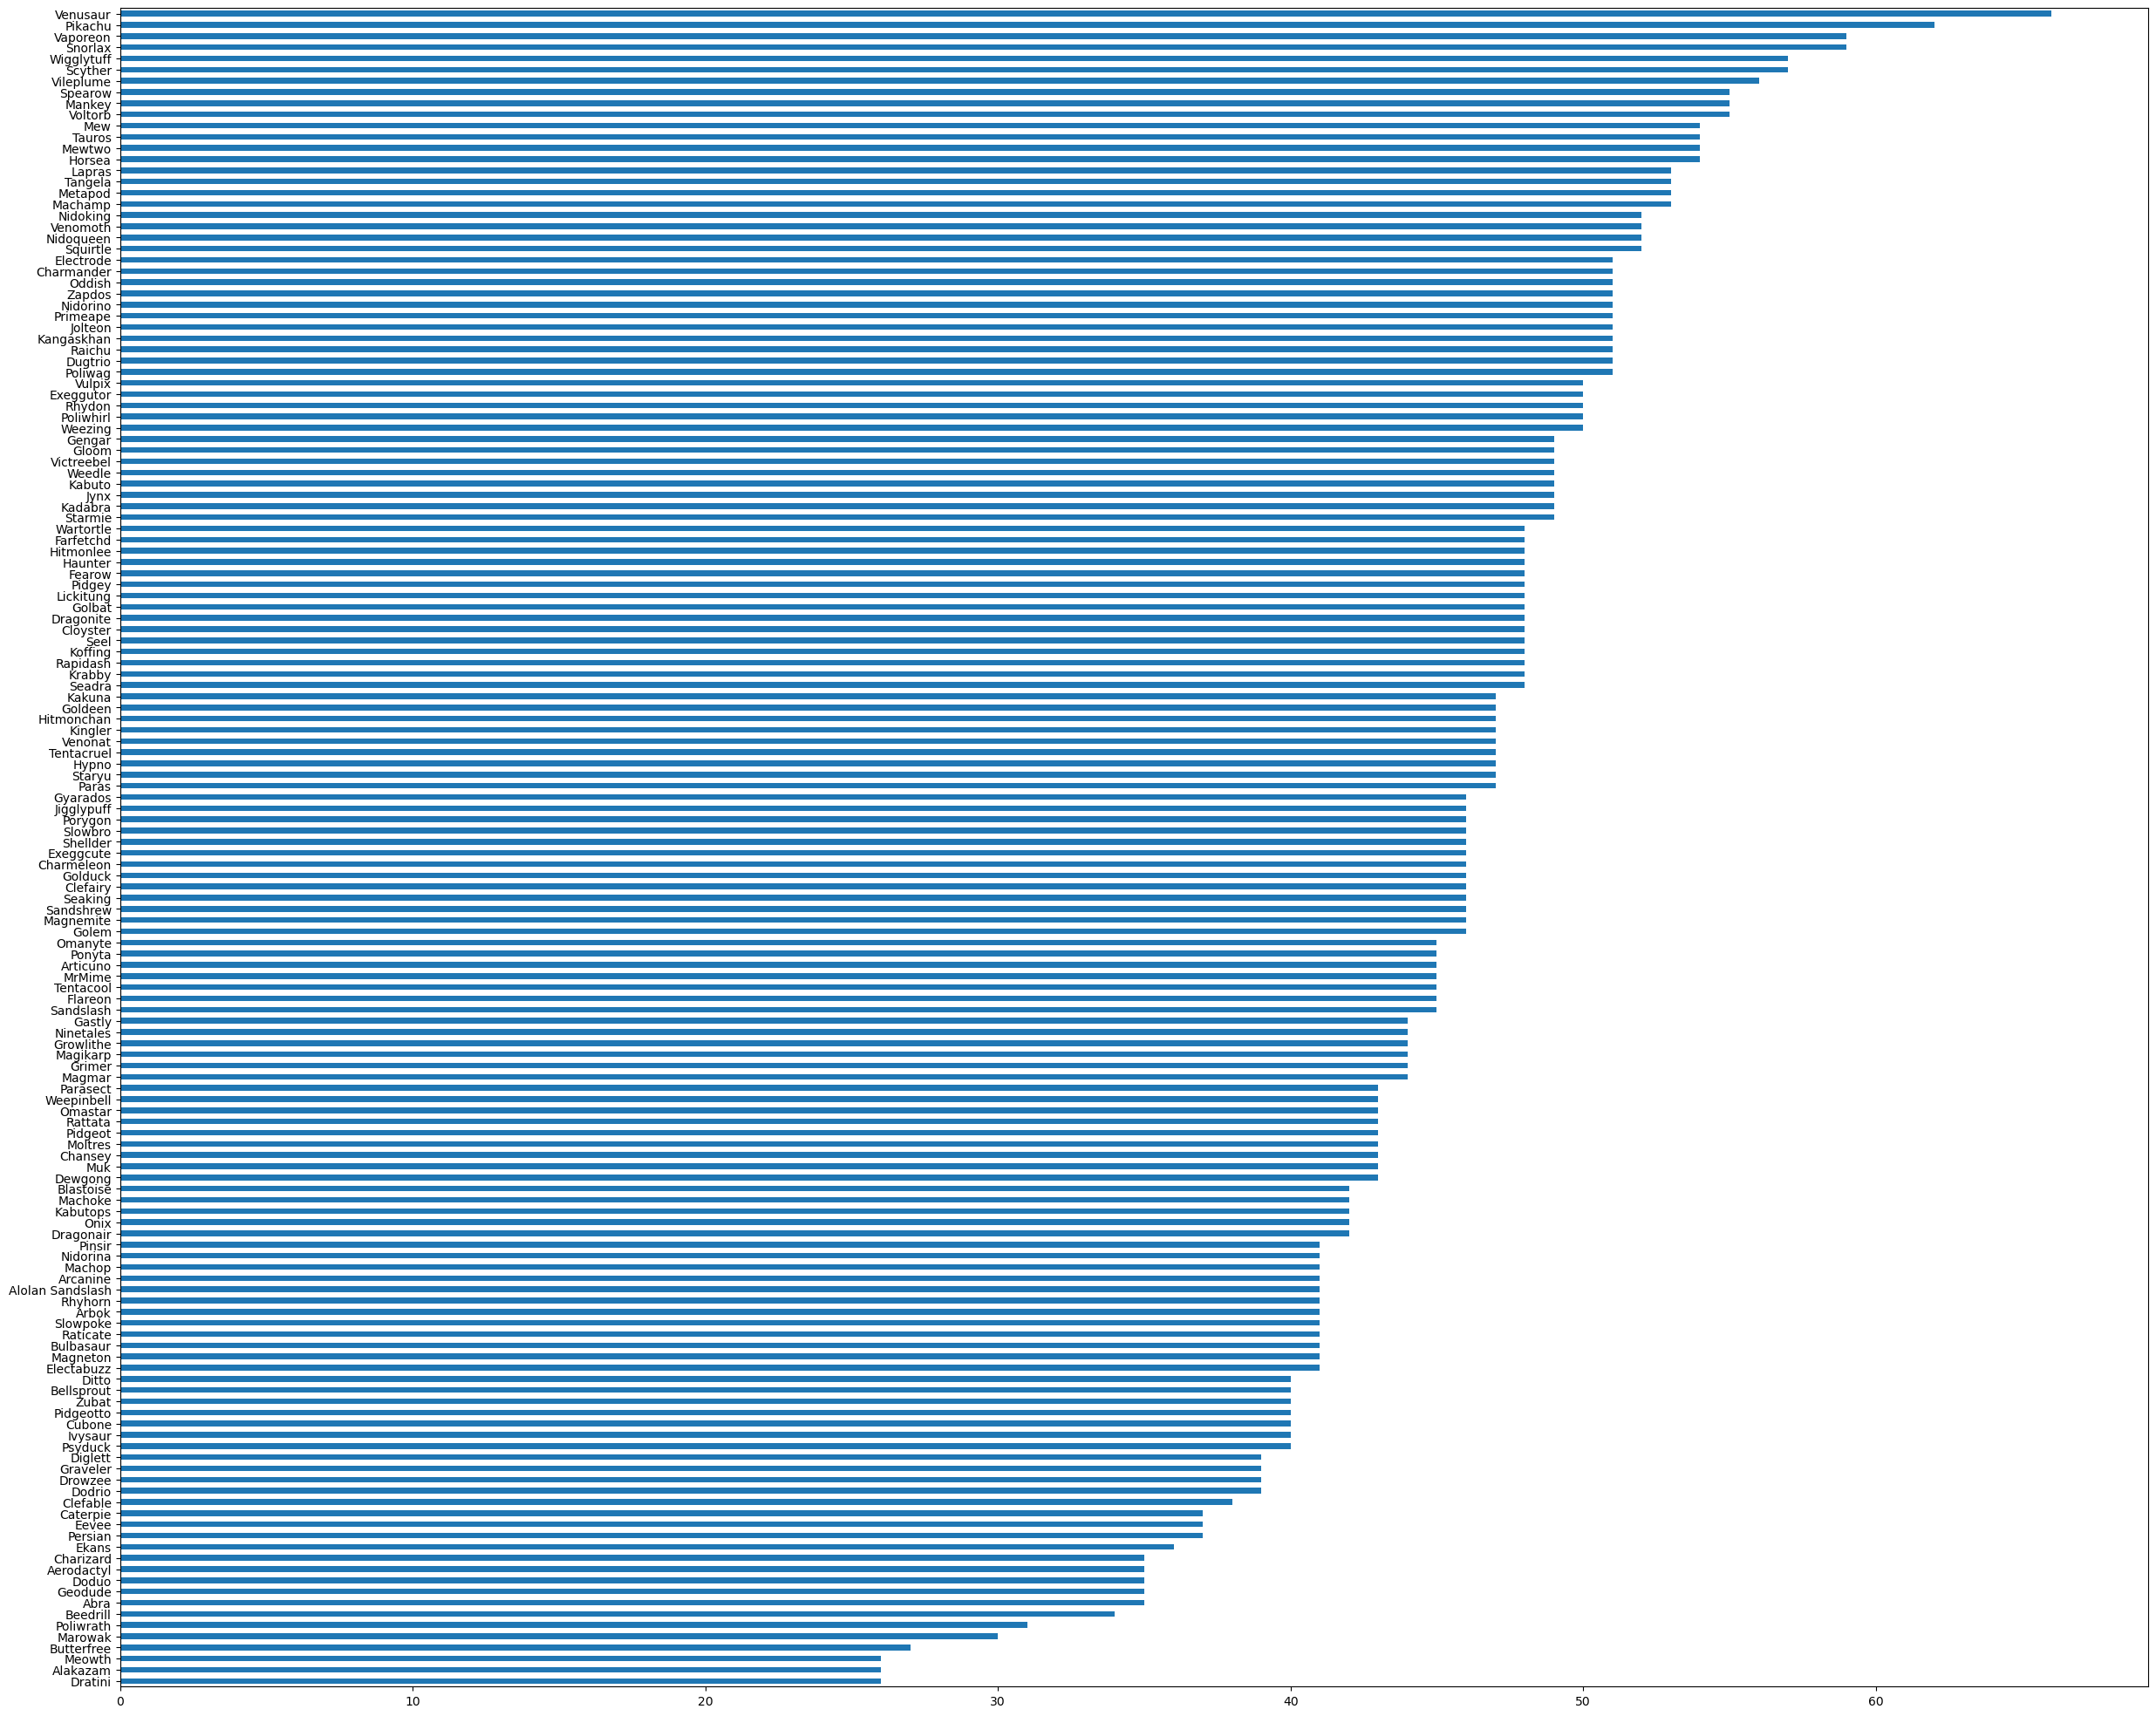

In [6]:
plt.figure(figsize=(30,25))
df_dados['target'].value_counts(ascending=True).plot(kind='barh')

plt.show()

In [7]:
heights = []
widths = []

# iterar através das imagens no diretório
for filename in df_dados['image']:
    # abrir imagem
    img = Image.open(filename)
    # obter dimensões
    width, height = img.size
    # adicionar dimensões à lista
    widths.append(width)
    heights.append(height)

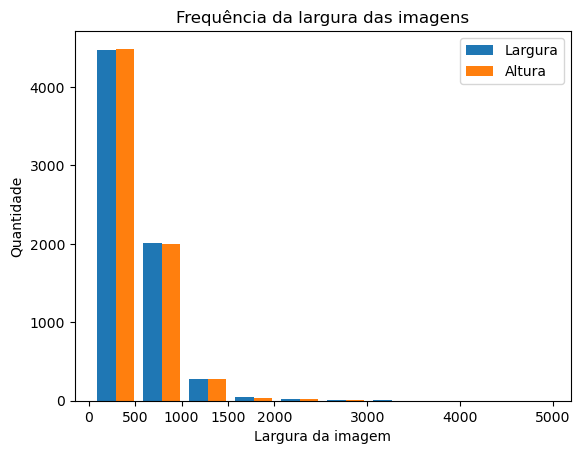

In [8]:
plt.hist([widths, heights])

plt.title("Frequência da largura das imagens")

plt.xlabel("Largura da imagem")
plt.ylabel("Quantidade")

plt.legend(["Largura", "Altura"])

plt.xticks([0, 500, 1000, 1500, 2000, 3000, 4000, 5000])

plt.show()

In [9]:
# calcular tamanho médio
mean_width = sum(w for w in widths) / len(widths)
mean_height = sum(h for h in heights) / len(heights)

print(f"Tamanho médio das imagens em relação a \nwidth: {mean_width} \nheight: {mean_height}")

Tamanho médio das imagens em relação a 
width: 470.407032967033 
height: 466.21758241758243


In [10]:
sorted_widths = sorted(widths)
sorted_heights = sorted(heights)

num_images = len(widths)

if num_images % 2 == 0:
    median_width = (sorted_widths[num_images//2 - 1] + sorted_widths[num_images//2]) / 2
    median_height = (sorted_heights[num_images//2 - 1] + sorted_heights[num_images//2]) / 2
else:
    median_width = sorted_widths[num_images//2]
    median_height = sorted_heights[num_images//2]
    
print(f"Mediana das imagens em relação a \nwidth: {median_width} \nheight: {median_height}")

Mediana das imagens em relação a 
width: 354 
height: 353


In [11]:
print(f"Tamanho da menor imagem em relação a \nwidth: {min(widths)} \nheight: {min(heights)}")

Tamanho da menor imagem em relação a 
width: 43 
height: 42


In [12]:
print(f"Tamanho da maior imagem em relação a \nwidth: {max(widths)} \nheight: {max(heights)}")

Tamanho da maior imagem em relação a 
width: 5000 
height: 4356


In [13]:
largura = math.floor(mean_width)
altura = math.floor(mean_height)

## Gerando mais imagens a partir do dataset

In [14]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20, 20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

In [15]:
data_images_generator = ImageDataGenerator(rescale=1./255, # rescalar
                                            rotation_range=40, # rotacionar imagem
                                            width_shift_range=0.2, # deslocamento horizontal
                                            height_shift_range=0.2, # deslocamento vertical
                                            shear_range=0.2, # cisalhamento
                                            zoom_range=0.2, # zoom
                                            horizontal_flip=True, # inverter horizontalmente
                                            fill_mode='nearest')

In [16]:
#data_gen = data_images_generator.flow_from_directory(batch_size=BATCH_SIZE,
#                                                     directory=diretorio,
#                                                     shuffle=True,
#                                                     target_size=(largura,altura))

data_gen = data_images_generator.flow_from_dataframe(batch_size=BATCH_SIZE,
                                                     dataframe=df_dados,
                                                     x_col='image',
                                                     y_col='target',
                                                     shuffle=True,
                                                     target_size=(largura,altura))

Found 6820 validated image filenames belonging to 150 classes.


C:\Users\wende\anaconda3\envs\data-science\lib\site-packages\keras\preprocessing\image.py:1139: UserWarning: Found 5 invalid image filename(s) in x_col="image". These filename(s) will be ignored.
  warnings.warn(


In [17]:
data_gen.class_indices

{'Abra': 0,
 'Aerodactyl': 1,
 'Alakazam': 2,
 'Alolan Sandslash': 3,
 'Arbok': 4,
 'Arcanine': 5,
 'Articuno': 6,
 'Beedrill': 7,
 'Bellsprout': 8,
 'Blastoise': 9,
 'Bulbasaur': 10,
 'Butterfree': 11,
 'Caterpie': 12,
 'Chansey': 13,
 'Charizard': 14,
 'Charmander': 15,
 'Charmeleon': 16,
 'Clefable': 17,
 'Clefairy': 18,
 'Cloyster': 19,
 'Cubone': 20,
 'Dewgong': 21,
 'Diglett': 22,
 'Ditto': 23,
 'Dodrio': 24,
 'Doduo': 25,
 'Dragonair': 26,
 'Dragonite': 27,
 'Dratini': 28,
 'Drowzee': 29,
 'Dugtrio': 30,
 'Eevee': 31,
 'Ekans': 32,
 'Electabuzz': 33,
 'Electrode': 34,
 'Exeggcute': 35,
 'Exeggutor': 36,
 'Farfetchd': 37,
 'Fearow': 38,
 'Flareon': 39,
 'Gastly': 40,
 'Gengar': 41,
 'Geodude': 42,
 'Gloom': 43,
 'Golbat': 44,
 'Goldeen': 45,
 'Golduck': 46,
 'Golem': 47,
 'Graveler': 48,
 'Grimer': 49,
 'Growlithe': 50,
 'Gyarados': 51,
 'Haunter': 52,
 'Hitmonchan': 53,
 'Hitmonlee': 54,
 'Horsea': 55,
 'Hypno': 56,
 'Ivysaur': 57,
 'Jigglypuff': 58,
 'Jolteon': 59,
 'Jynx': 60,

In [18]:
data_gen.samples

6820

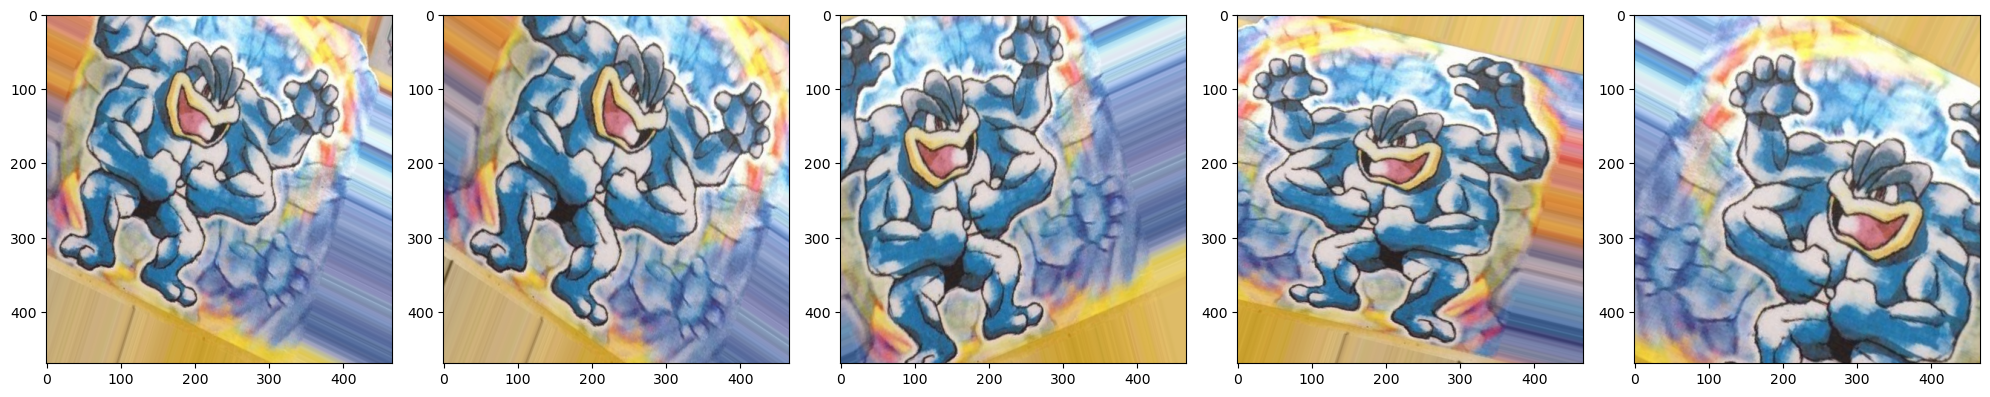

In [19]:
images = [data_gen[0][0][8] for i in range(5)]
plotImages(images)

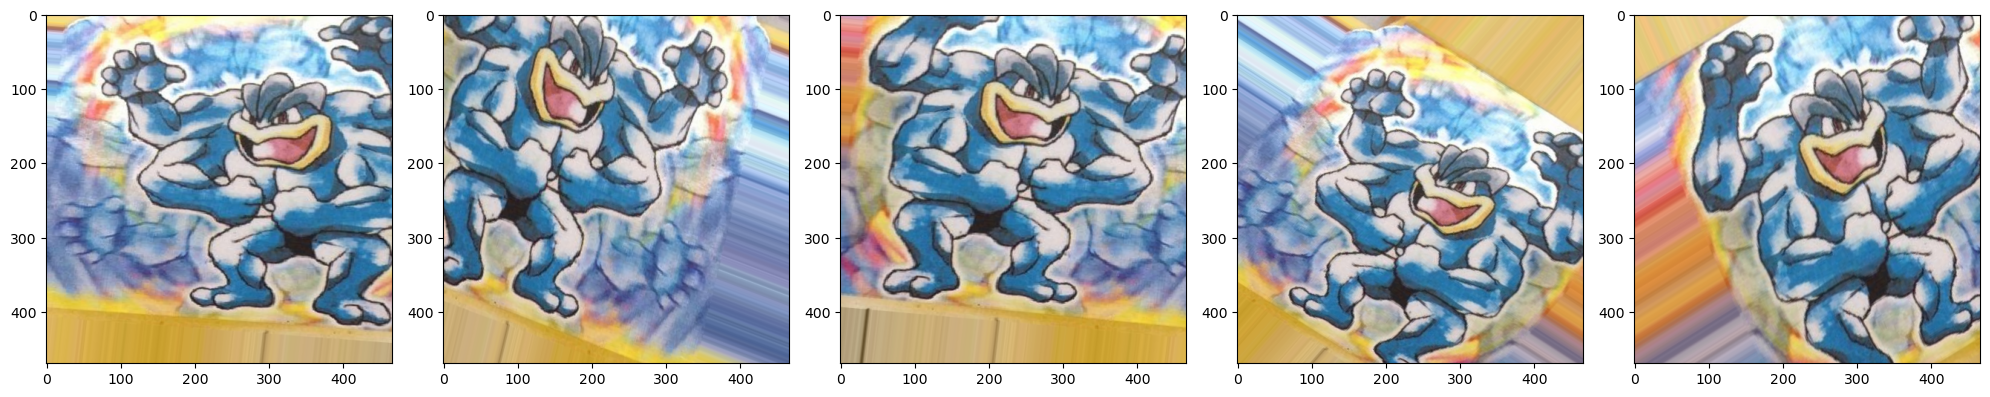

In [20]:
images = [data_gen[0][0][8] for i in range(465, 470)]
plotImages(images)

## Preparando Dados

In [91]:
def getEmbedder():
    # return EfficientNetB0(weights='imagenet', include_top=False)
    # return EfficientNetB2(weights='imagenet', include_top=False)
    # return EfficientNetB3(weights='imagenet', include_top=False)
    # return EfficientNetB4(weights='imagenet', include_top=False)
    # return EfficientNetB7(weights='imagenet', include_top=False)
    return InceptionV3(weights='imagenet', include_top=False)
    # return Xception(weights='imagenet', include_top=False)
    # return DenseNet201(weights='imagenet', include_top=False)

def embedding(embedder, img_path, largura, altura, modo_de_cor):
    img = image.load_img(img_path, target_size=(largura, altura),color_mode= modo_de_cor)
    embed = image.img_to_array(img)
    embed = np.expand_dims(embed, axis=0)
        # embed = preprocess_input(embed)

    features = embedder.predict(embed)

    return features[0][0][0]

def embeddingTest(embedder, img_path, largura, altura, modo_de_cor, n_transformations):
    img = image.load_img(img_path, target_size=(largura, altura),color_mode= modo_de_cor)
    
    array_img_transformed = []
    
    # FAZER NA IMAGEM ORINAL SEM MUDAR NADA
    img_transformed = image.img_to_array(img)

    embed = np.expand_dims(img_transformed, axis=0)
    # embed = preprocess_input(embed)

    features = embedder.predict(embed)
    
    array_img_transformed.append(features[0][0][0])
        
    for _ in range(n_transformations):
        
        img_transformed = data_images_generator.random_transform(image.img_to_array(img))

        embed = np.expand_dims(img_transformed, axis=0)
            # embed = preprocess_input(embed)

        features = embedder.predict(embed)
        
        array_img_transformed.append(features[0][0][0])

    return np.array(array_img_transformed)

def embeddingWithoutModel(img_path, largura, altura, modo_de_cor):
    
    img = image.load_img(img_path, target_size=(largura, altura),color_mode= modo_de_cor)
    embed = image.img_to_array(img)
    
    shape_entrada = largura*altura*1

    if(modo_de_cor == 'rgb'):
        shape_entrada = largura*altura*3

    if(modo_de_cor == 'rgba'):
        shape_entrada = largura*altura*4
    
    return embed.reshape(shape_entrada)

embedder = getEmbedder()

In [92]:
#tf.config.experimental.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(tf.config.experimental.list_physical_devices('GPU')[0], True)

In [93]:
target = df_dados['target'].array
n_transformations = 2

array_features = []
for x in dados:
    #array_features.append(embedding(embedder, x[0], largura, altura, modo_de_cor))
    array_features.extend(embeddingTest(embedder, x[0], largura, altura, modo_de_cor, n_transformations))
    # array_features.append(embeddingWithoutModel(x[0], largura, altura, modo_de_cor))

scaler = preprocessing.StandardScaler()

# array_features = np.array(array_features, dtype=np.uint8)

array_features = scaler.fit_transform(array_features)

df_features = pd.DataFrame(array_features)

df_features

1/1 [==============================] - 0s 48ms/step


0         1         2         3         4         5         6     \
0      0.718577  0.264140  3.963246  0.274169  0.903224 -0.319414 -0.181308   
1     -0.204240 -0.149653 -0.168387 -0.386129  2.040869 -0.319414 -0.181308   
2     -0.117677 -0.149653 -0.168387 -0.391818  0.879523  0.051288 -0.181308   
3     -0.204240 -0.149653 -0.168387  0.035374 -0.373210 -0.319414 -0.181308   
4     -0.204240 -0.149653 -0.168387 -0.204479 -0.373210  0.064677 -0.181308   
...         ...       ...       ...       ...       ...       ...       ...   
20470 -0.204240 -0.149653 -0.168387  0.106783 -0.373210 -0.319414 -0.181308   
20471 -0.204240 -0.149653 -0.168387 -0.073004  0.157763 -0.319414 -0.181308   
20472 -0.175544 -0.149653 -0.168387  0.989942 -0.373210 -0.319414  1.807029   
20473 -0.204240 -0.149653 -0.168387 -0.139602 -0.373210 -0.319414 -0.181308   
20474 -0.204240 -0.149653 -0.168387 -0.526769 -0.373210 -0.319414 -0.181308   

           7         8         9     ...      2038      2039      2040  \
0     -1.125919 -0.184605 -0.056104  ...  0.758602 -0.290198 -0.341859   
1     -1.125919 -0.184605 -0.642165  ...  0.154230 -0.290198 -0.150916   
2     -1.036563 -0.184605 -0.375127  ...  0.230848 -0.290198 -0.341859   
3      0.129834 -0.184605 -1.024112  ... -0.522111  1.748263 -0.341859   
4      0.484583 -0.184605  1.996176  ... -0.522111  3.496846 -0.341859   
...         ...       ...       ...  ...       ...       ...       ...   
20470  0.370018 -0.184605  2.096561  ... -0.522111 -0.290198 -0.341859   
20471  0.118082 -0.184605  1.329865  ... -0.189783 -0.290198 -0.341859   
20472 -0.154360 -0.184605 -1.024112  ...  2.630363 -0.290198 -0.341859   
20473 -0.457360 -0.184605 -0.027580  ... -0.522111 -0.290198 -0.341859   
20474  1.752497 -0.122281  1.664290  ... -0.383714 -0.290198 -0.341859   

           2041      2042      2043      2044      2045      2046      2047  
0      0.721131 -0.317274 -0.889394 -1.109717 -0.178168 -0.178671 -0.272481  
1      1.367611 -0.444002 -0.722350 -1.109717 -0.178168 -0.178671 -0.272481  
2      0.308156 -0.444002 -0.896259 -1.109717 -0.178168 -0.178671 -0.272481  
3     -0.499578 -0.444002 -0.569715 -0.380894 -0.178168 -0.178671 -0.272481  
4     -0.499578 -0.444002 -0.896259 -0.305669 -0.178168 -0.178671 -0.272481  
...         ...       ...       ...       ...       ...       ...       ...  
20470 -0.421689 -0.444002 -0.896259 -0.428575 -0.178168 -0.178671 -0.272481  
20471 -0.499578 -0.444002 -0.116903  0.453080 -0.178168 -0.178671 -0.272481  
20472 -0.499578 -0.006470  2.338805 -1.109717 -0.178168 -0.178671 -0.272481  
20473 -0.499578 -0.444002 -0.419552  0.226977 -0.178168 -0.178671 -0.272481  
20474 -0.499578 -0.444002 -0.310619 -0.982532 -0.178168 -0.178671 -0.272481  

[20475 rows x 2048 columns]

In [94]:
target_transformation = np.repeat(target, n_transformations + 1) # imagens transformadas + a original

target_transformation

<PandasArray>
[  'Diglett',   'Diglett',   'Diglett',  'Articuno',  'Articuno',  'Articuno',
 'Exeggutor', 'Exeggutor', 'Exeggutor',  'Kabutops',
 ...
  'Rapidash', 'Exeggcute', 'Exeggcute', 'Exeggcute',  'Vaporeon',  'Vaporeon',
  'Vaporeon',  'Venusaur',  'Venusaur',  'Venusaur']
Length: 20475, dtype: object

## Reduzindo a Dimensionalidade

In [ ]:
model = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=50)
array_red = model.fit_transform(df_features) 

df_tsne = pd.DataFrame(array_red)

df_tsne['target'] = target_transformation

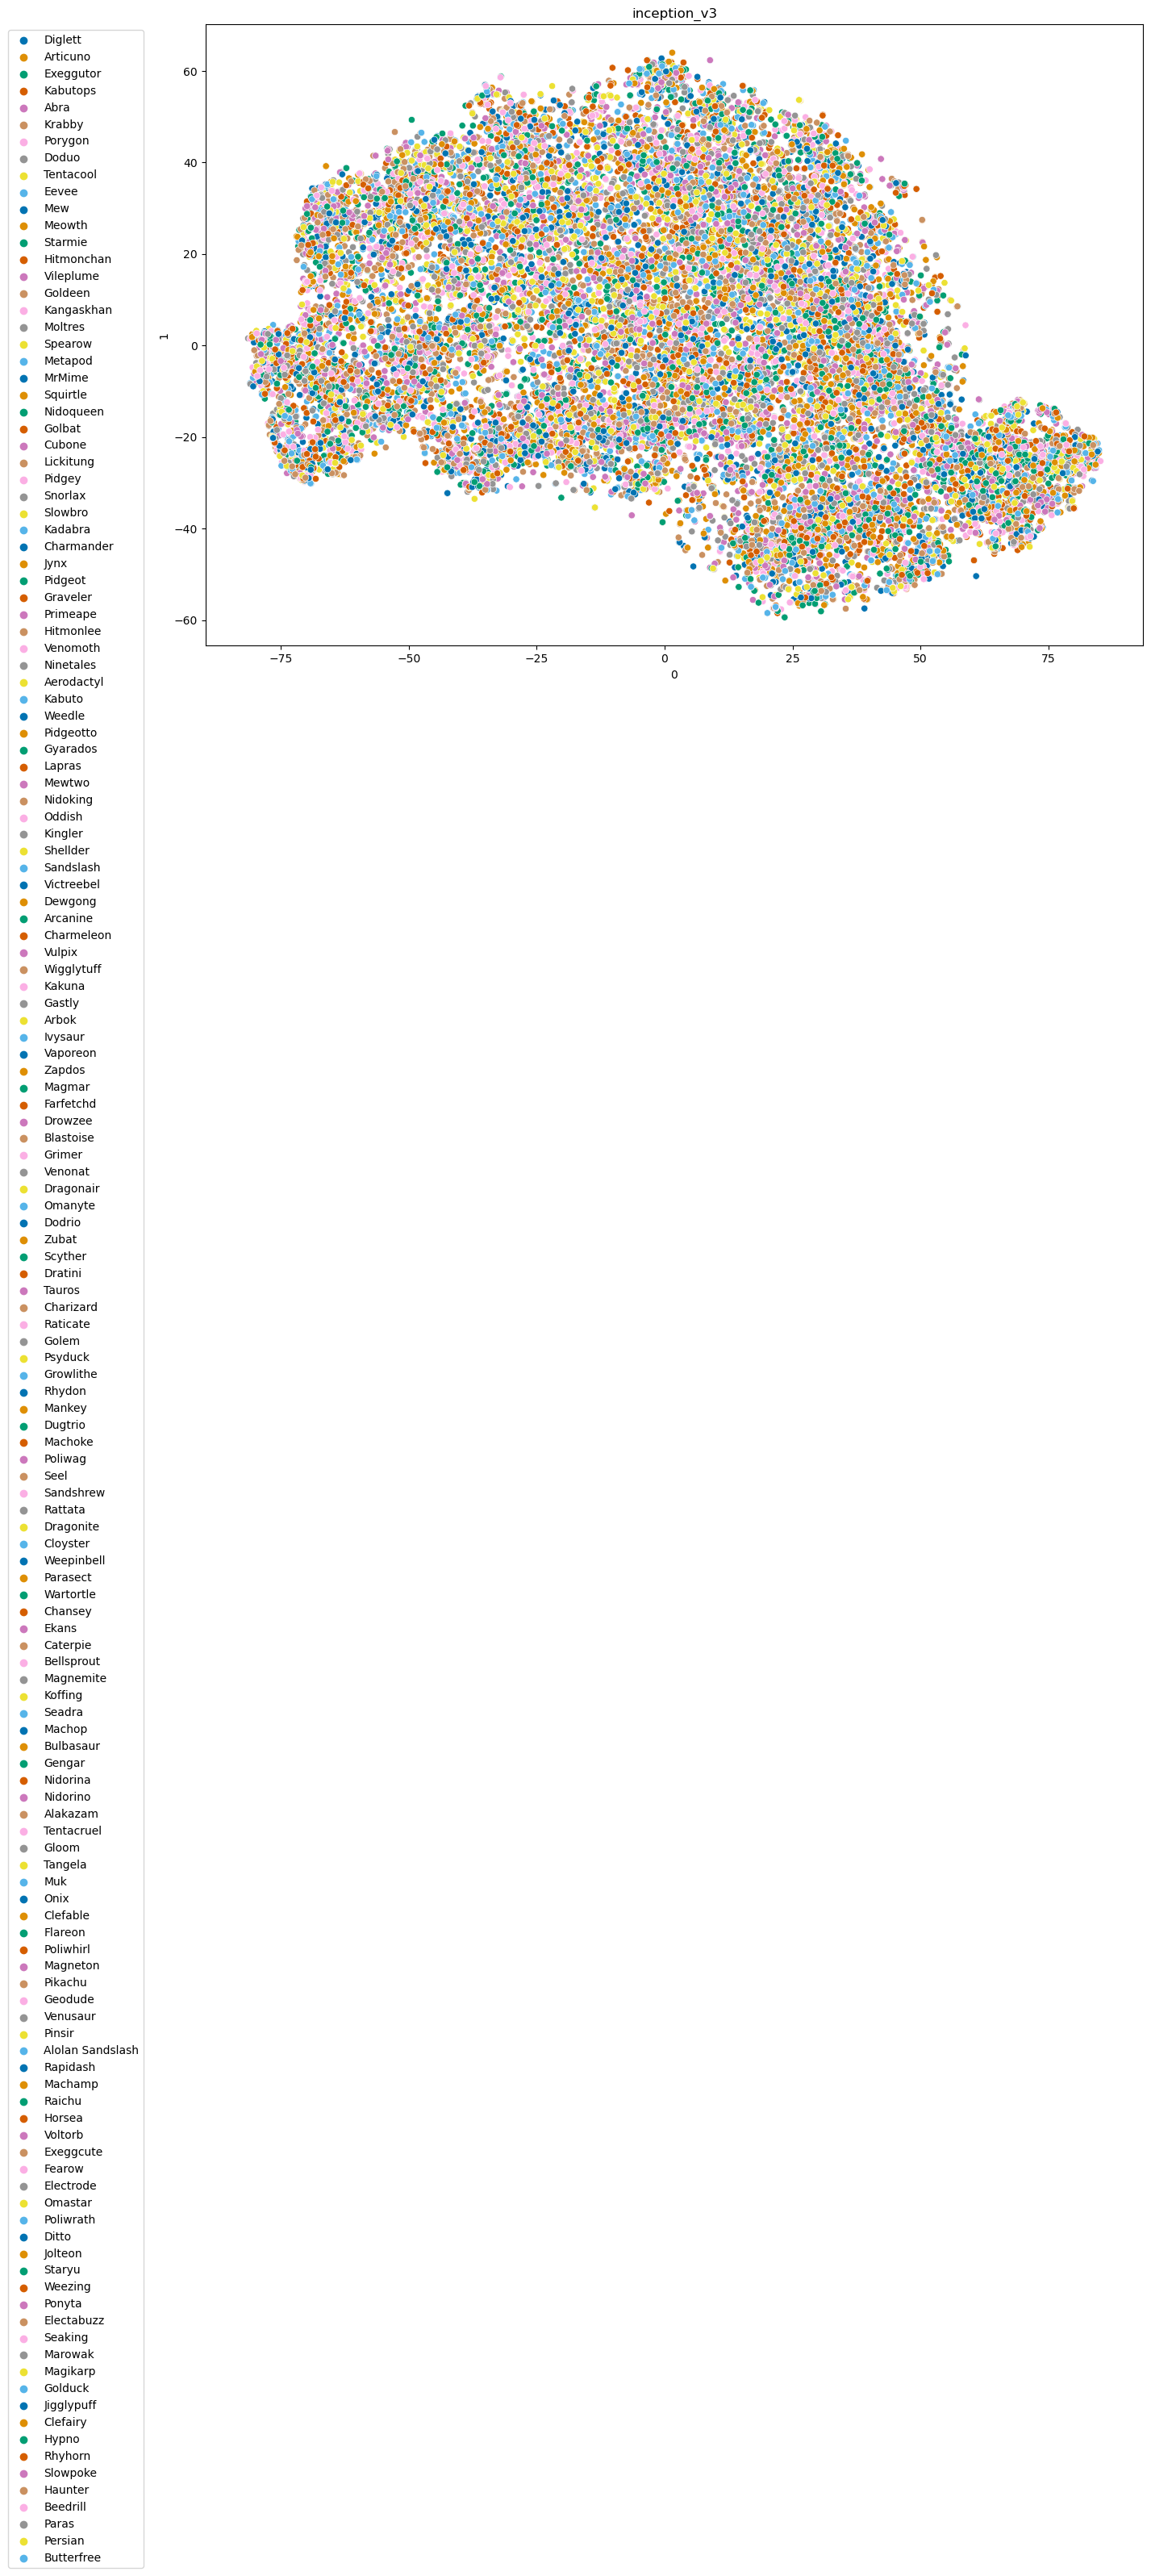

In [ ]:
plt.rcParams['figure.figsize'] = [15, 10]

sns.scatterplot(data=df_tsne, x=df_tsne[0], y=df_tsne[1], hue=df_tsne['target'], palette="colorblind")

plt.legend(loc = 'best', bbox_to_anchor=(-0.06, 1))

plt.title(getEmbedder().name)

plt.savefig(f"Embedding {getEmbedder().name}", bbox_inches="tight")

plt.show()

## Mostrando só algumas classes da redução de dimensionalidade

In [ ]:
ten_classes = df_tsne['target'].unique()[0:10]

ten_classes

array(['Diglett', 'Articuno', 'Exeggutor', 'Kabutops', 'Abra', 'Krabby',
       'Porygon', 'Doduo', 'Tentacool', 'Eevee'], dtype=object)

In [ ]:
df_tsne_filter_by_ten_classes = df_tsne[df_tsne['target'].isin(ten_classes)]

df_tsne_filter_by_ten_classes.head()

0          1    target
0  70.823341 -31.604502   Diglett
1  64.930412 -30.016134   Diglett
2  58.271248 -32.853889   Diglett
3   1.729484  20.086004  Articuno
4  44.638931  -0.703932  Articuno

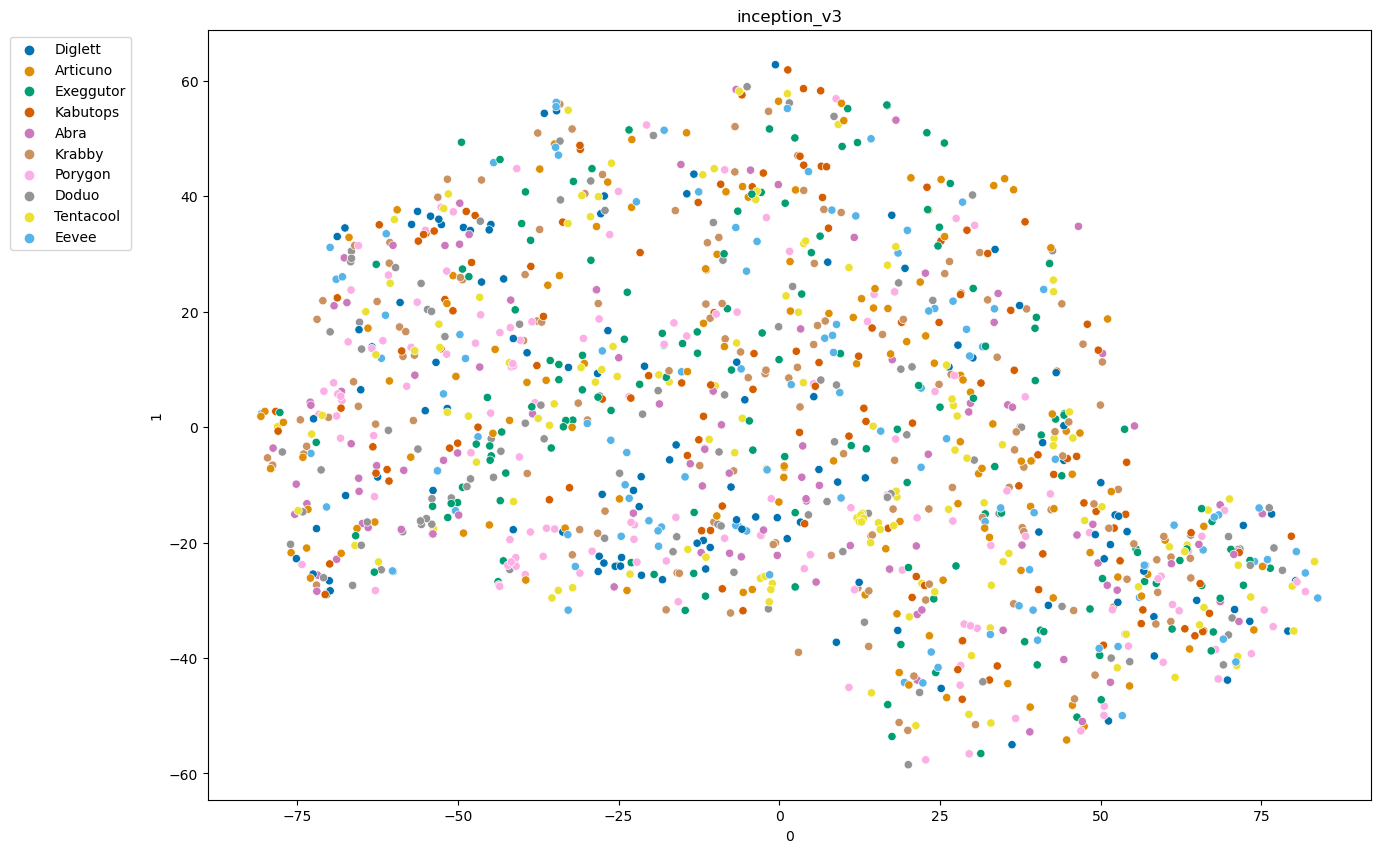

In [ ]:
plt.rcParams['figure.figsize'] = [15, 10]

sns.scatterplot(data=df_tsne_filter_by_ten_classes, x=df_tsne_filter_by_ten_classes[0], y=df_tsne_filter_by_ten_classes[1], hue=df_tsne_filter_by_ten_classes['target'], palette="colorblind")

plt.legend(loc = 'best', bbox_to_anchor=(-0.06, 1))

plt.title(getEmbedder().name)

plt.savefig(f"Embedding {getEmbedder().name} - Filtered by 10 Classes", bbox_inches="tight")

plt.show()

## Treinando e Validando o Modelo

In [109]:
def getModel():
    # Ensemble
    # return RandomForestClassifier(n_jobs=12)
    # return AdaBoostClassifier()

    # Linear
    # return LogisticRegression(n_jobs=-1)#n_jobs=12, solver='sag', multi_class='ovr')
    # return SGDClassifier(n_jobs=12,early_stopping=True,validation_fraction=0.05)

    # Tree
    # return DecisionTreeClassifier()
    
    # Neighbors
    # return KNeighborsClassifier(n_neighbors=3,n_jobs=12)
    
    # Support Vector Machines - SVM
    # return SVC()
    
    # Instalados a parte
    # return XGBClassifier()
    # return LGBMClassifier(n_jobs=-1) # - mais leve que o XGB

In [110]:
X_treino, X_teste, y_treino, y_teste = train_test_split(df_features.values,target_transformation,test_size=percentege_test_size)

model = getModel().fit(X_treino, y_treino)

score = model.score(X_teste, y_teste)

score

0.026373626373626374

## Validando

In [111]:
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average='weighted'),
    'recall': make_scorer(recall_score, average='weighted'),
    'f1': make_scorer(f1_score, average='weighted')
}

In [116]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scores = cross_validate(getModel(),df_features.values,target_transformation,cv=cv,scoring=scoring)

scores

{'fit_time': array([61.84492064, 64.02468657, 59.16627336, 61.56342983, 58.42327905]),
 'score_time': array([0.29299903, 0.25179362, 0.21100569, 0.20499206, 0.21101117]),
 'test_accuracy': array([0.03272283, 0.03882784, 0.03687424, 0.03394383, 0.04004884]),
 'test_precision': array([0.03399789, 0.03895065, 0.03511578, 0.03449722, 0.03921321]),
 'test_recall': array([0.03272283, 0.03882784, 0.03687424, 0.03394383, 0.04004884]),
 'test_f1': array([0.03260345, 0.03828677, 0.03548348, 0.03365585, 0.03877527])}

In [117]:
print('Acurácia média:', scores['test_accuracy'].mean())
print('Precisão média:', scores['test_precision'].mean())
print('Recall médio:', scores['test_recall'].mean())
print('F1 médio:', scores['test_f1'].mean())

Acurácia média: 0.036483516483516484
Precisão média: 0.03635495116000805
Recall médio: 0.036483516483516484
F1 médio: 0.03576096372467751


scores = cross_val_score(getModel(),df_features.values,target_transformation,cv=5)

np.mean(scores)

## Visualizando Matriz de Confusão

predicoes = cross_val_predict(getModel(),df_features.values,target,cv=5)

cm = confusion_matrix(target, predicoes)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=model.classes_)
disp.plot()

plt.show()

## Usando Redes neurais com "transfer learning"

In [130]:
data_images_generator_train = ImageDataGenerator(rescale=1./255, # rescalar
                                            rotation_range=40, # rotacionar imagem
                                            width_shift_range=0.2, # deslocamento horizontal
                                            height_shift_range=0.2, # deslocamento vertical
                                            shear_range=0.2, # cisalhamento
                                            zoom_range=0.2, # zoom
                                            horizontal_flip=True, # inverter horizontalmente
                                            fill_mode='nearest')

data_images_generator_test = ImageDataGenerator(rescale=1./255)

In [149]:
x_train_balanced, x_val_balanced, y_train_balanced, y_val_balanced = train_test_split(df_dados['image'], df_dados['target'], test_size=0.2, stratify=df_dados['target'])


In [150]:
print(f'{len(x_train_balanced)} + {len(x_val_balanced)} = {len(x_train_balanced) + len(x_val_balanced)}')

5460 + 1365 = 6825


In [151]:
print(f'{len(y_train_balanced)} + {len(y_val_balanced)} = {len(y_train_balanced) + len(y_val_balanced)}')

5460 + 1365 = 6825


In [157]:
df_dados_train = pd.DataFrame({'image': x_train_balanced, 'target': y_train_balanced})

df_dados_train

image    target
5073  ./PokemonData/Arcanine/0af612d6c81c4cf8bb346df...  Arcanine
6618  ./PokemonData/Paras/55b90fe85c0749d99e9212ba99...     Paras
3909                ./PokemonData/Squirtle/00000015.png  Squirtle
5252  ./PokemonData/Squirtle/4d762b74e6884feeb216e71...  Squirtle
2076  ./PokemonData/Nidoking/460351fa75384cfebdc75eb...  Nidoking
...                                                 ...       ...
624   ./PokemonData/Venomoth/13e1f8d7e7f84d8da1d2cb2...  Venomoth
5454  ./PokemonData/Diglett/f6743301bccf4aff857f42d3...   Diglett
4064  ./PokemonData/Doduo/03c73c8269964c5d987cad3df9...     Doduo
4590  ./PokemonData/Golbat/914fab74d32e49a98940d5ba7...    Golbat
4857  ./PokemonData/Lapras/b0e9e0722fbf45aea40e6147b...    Lapras

[5460 rows x 2 columns]

In [158]:
df_dados_test= pd.DataFrame({'image': x_val_balanced, 'target': y_val_balanced})

df_dados_test

image     target
487   ./PokemonData/Nidorino/f05ea8a5fe334839aa10448...   Nidorino
6719  ./PokemonData/Dewgong/6d2565fc45104860a1d1d08d...    Dewgong
6771  ./PokemonData/Grimer/4accc64f2ed2485bafb00a4b0...     Grimer
3985  ./PokemonData/Magneton/60e1bc64ead04f18aba351a...   Magneton
2032  ./PokemonData/Pikachu/9e315cea4c944136a9b1f30b...    Pikachu
...                                                 ...        ...
1881  ./PokemonData/Nidorino/df96cd1a14304931af5e95b...   Nidorino
2737  ./PokemonData/Scyther/503857768d4e4812b4efd5b1...    Scyther
5324  ./PokemonData/Charizard/8678317629364576b100fd...  Charizard
4112  ./PokemonData/Spearow/4a987268cbee41f39960611e...    Spearow
250   ./PokemonData/Drowzee/5c7b8004a25c4d8ab78f7f04...    Drowzee

[1365 rows x 2 columns]

In [159]:
data_gen_train = data_images_generator_train.flow_from_dataframe(batch_size=BATCH_SIZE,
                                                     dataframe=df_dados_train,
                                                     x_col='image',
                                                     y_col='target',
                                                     shuffle=True,
                                                     target_size=(largura,altura))

data_gen_test= data_images_generator_test.flow_from_dataframe(batch_size=BATCH_SIZE,
                                                     dataframe=df_dados_test,
                                                     x_col='image',
                                                     y_col='target',
                                                     shuffle=False,
                                                     target_size=(largura,altura))


Found 5455 validated image filenames belonging to 150 classes.
Found 1365 validated image filenames belonging to 150 classes.


C:\Users\wende\anaconda3\envs\data-science\lib\site-packages\keras\preprocessing\image.py:1139: UserWarning: Found 5 invalid image filename(s) in x_col="image". These filename(s) will be ignored.
  warnings.warn(


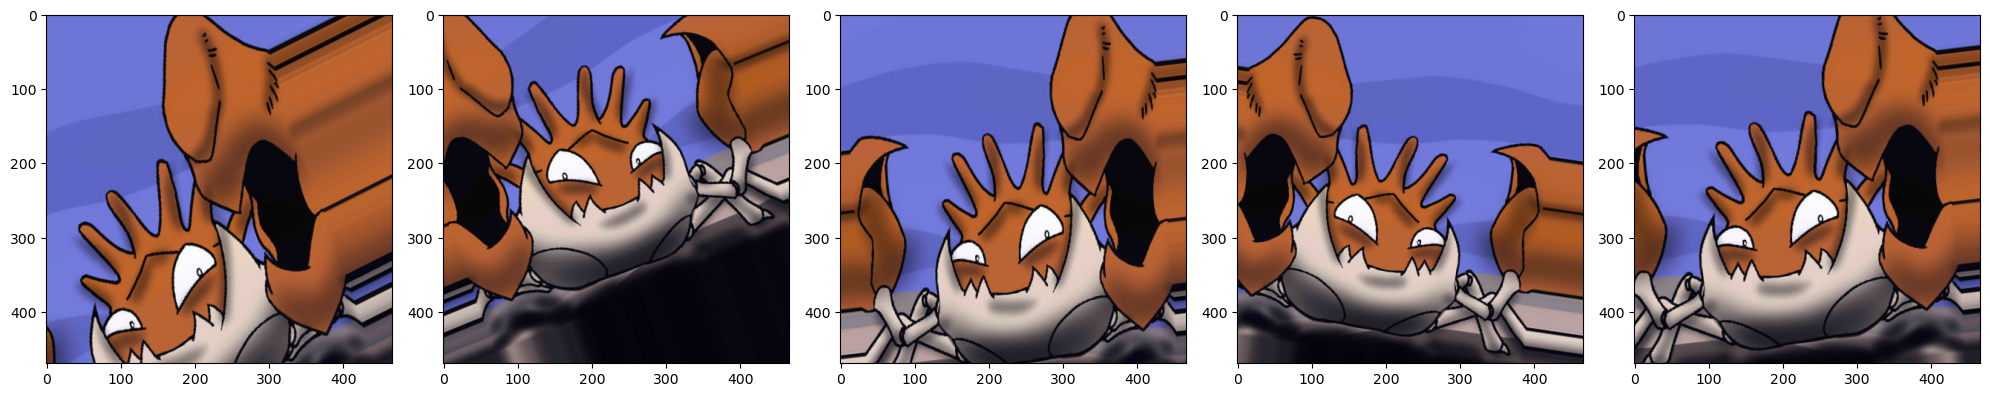

In [160]:
images = [data_gen_train[0][0][8] for i in range(5)]
plotImages(images)

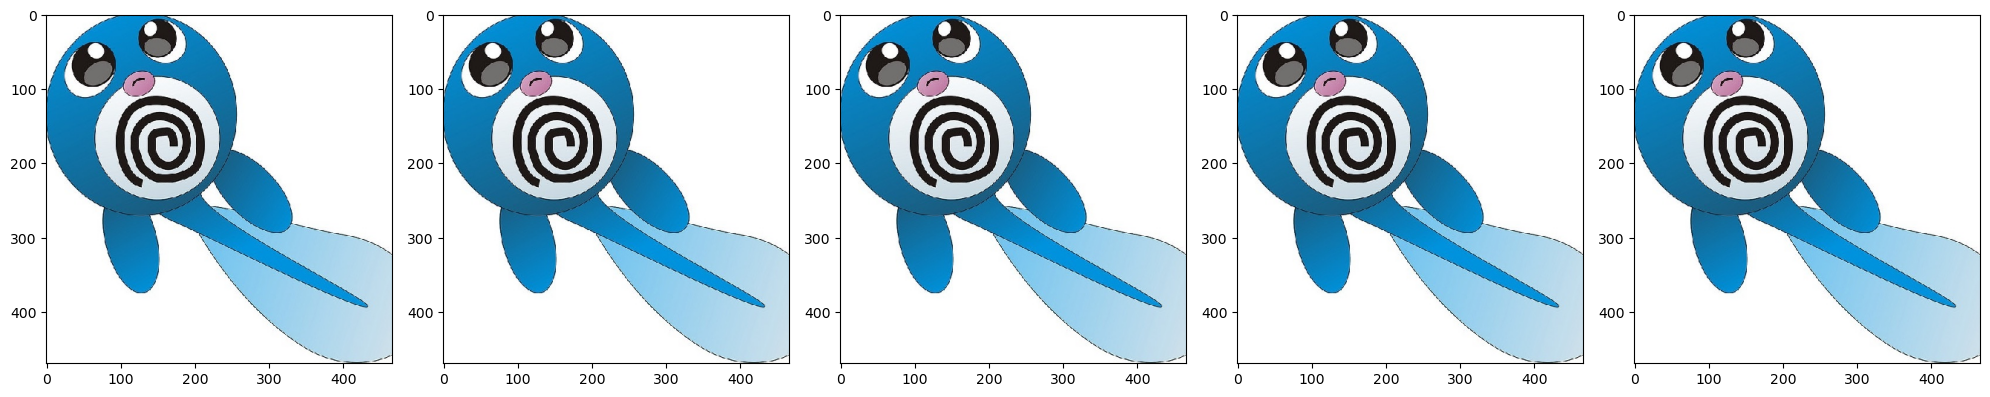

In [161]:
images = [data_gen_test[0][0][8] for i in range(5)]
plotImages(images)

In [162]:
conv_base = keras.applications.Xception(weights='imagenet', include_top=False,
                  input_shape=(largura,altura,3))
conv_base.trainable = False

In [163]:
my_init = keras.initializers.glorot_uniform(seed = 1)
model = keras.models.Sequential([
    conv_base,
    
    keras.layers.GlobalAveragePooling2D(),
    
    keras.layers.Flatten(),
    keras.layers.Dropout(0.3),

    keras.layers.Dense(1024, activation='relu', kernel_initializer = my_init),
    keras.layers.Dense(512, activation='relu', kernel_initializer = my_init),
    keras.layers.Dense(256, activation='relu', kernel_initializer = my_init),

    keras.layers.Dense(150, activation='softmax', kernel_initializer = my_init)
                         
])

In [164]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [165]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 15, 15, 2048)      20861480  
                                                                 
 global_average_pooling2d_12  (None, 2048)             0         
  (GlobalAveragePooling2D)                                       
                                                                 
 flatten_12 (Flatten)        (None, 2048)              0         
                                                                 
 dropout_5 (Dropout)         (None, 2048)              0         
                                                                 
 dense_41 (Dense)            (None, 1024)              2098176   
                                                                 
 dense_42 (Dense)            (None, 512)               524800    
                                                     

In [166]:
EPOCHS = 10

In [171]:
history = model.fit_generator(
            data_gen_train,
            steps_per_epoch=np.ceil(len(data_gen_train) / BATCH_SIZE),
            epochs=EPOCHS,
            validation_data=data_gen_test,
            validation_steps=np.ceil(len(data_gen_test) / BATCH_SIZE))

C:\Users\wende\AppData\Local\Temp\ipykernel_23684\646170553.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/10
22/22 [==============================] - 22s 1s/step - loss: 5.0507 - accuracy: 0.0057 - val_loss: 5.0328 - val_accuracy: 0.0000e+00
Epoch 2/10
22/22 [==============================] - 27s 1s/step - loss: 5.0075 - accuracy: 0.0142 - val_loss: 5.0105 - val_accuracy: 0.0000e+00
Epoch 3/10
22/22 [==============================] - 26s 1s/step - loss: 5.0094 - accuracy: 0.0170 - val_loss: 4.9851 - val_accuracy: 0.0000e+00
Epoch 4/10
22/22 [==============================] - 23s 1s/step - loss: 4.9965 - accuracy: 0.0199 - val_loss: 4.9823 - val_accuracy: 0.0208
Epoch 5/10
22/22 [==============================] - 24s 1s/step - loss: 4.9957 - accuracy: 0.0085 - val_loss: 4.9701 - val_accuracy: 0.0312
Epoch 6/10
22/22 [==============================] - 23s 1s/step - loss: 4.9386 - accuracy: 0.0369 - val_loss: 4.9278 - val_accuracy: 0.0521
Epoch 7/10
22/22 [==============================] - 23s 1s/step - loss: 4.8761 - accuracy: 0.0256 - val_loss: 4.8196 - val_accuracy: 0.0521
Epoch 8/

KeyboardInterrupt: 